In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mdst # my data science tools
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, RFE
from scipy.stats import pearsonr
from scipy import stats

c:\python36-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# beginnings of my own convenience functions for feature engineering and data exploration
class Features_df():
    def __init__(self, df, y_col):
        self.df = df
        self.numeric_col_names = list(df.select_dtypes(exclude=[object]).columns)
        self.numeric_col_names.remove(y_col)
        self.categorical_col_names = list(df.select_dtypes(include=[object]).columns)
        self.added_col_names = []
        self.original_col_names = list(df.columns)
        self.y_col = y_col
        self.capped_outlier_col_names = []
        
    def get_dummies(self):
        self.dummy_dct = {}
        self.dropped_dummy = {}
        self.dummies_df = pd.DataFrame()

        for col_name in self.categorical_col_names:
            most_common = self.df[col_name].value_counts().index[0]
            dummies = pd.get_dummies(self.df[col_name]).drop(most_common, axis=1)
            
            for d_col_name in dummies.columns:
                if d_col_name in self.dummies_df.columns:
                    dummies[d_col_name+'_'+col_name] = dummies[d_col_name]
                    dummies = dummies.drop(d_col_name, axis=1)
            
            self.dummies_df = pd.concat([self.dummies_df, dummies], axis=1)
            self.dummy_dct[col_name] = list(dummies.columns)
            self.dropped_dummy[col_name] = most_common
        
        
        self.dummy_col_names = list(self.dummies_df.columns)
        self.df = pd.concat([self.df, self.dummies_df], axis=1)

    def get_poly_features(self, degree=2):
        poly = PolynomialFeatures(degree)
        poly_df = pd.DataFrame(poly.fit_transform(self.df[self.numeric_col_names]))
        self.poly_col_names = poly.get_feature_names()

        for i, col in reversed(list(enumerate(self.df[self.numeric_col_names]))):
            self.poly_col_names = [pcn.replace('x'+str(i),col) for pcn in self.poly_col_names]

        poly_df.columns = self.poly_col_names
        
        poly_df.index = self.df.index
        
#         self.poly_df = self.poly_df.drop(self.numeric_col_names, axis=1)
        self.df = pd.concat([self.df, poly_df.drop(self.numeric_col_names, axis=1)], axis=1)
        self.poly_col_names = [col for col in self.poly_col_names if col not in self.numeric_col_names]
    
    def standardize_cols(self, cols=None):
        if not cols:
            cols = self.numeric_col_names
        scaler = StandardScaler()
        self.st_cols = []
        for col in cols:
            new_col = col+'_scaled'
            self.df[new_col] = scaler.fit_transform(self.df[[col]]).reshape(-1,)
            self.st_cols.append(new_col)
    
    def box_all_standard(self, cols=None):
        if not cols:
            try:
                cols = self.st_cols
            except:
                self.standardize_cols()
                cols = self.st_cols

        plt.figure(figsize=(20, len(cols)))
        sns.boxplot(data=self.df[cols], orient='h')

        
    
    
    def display_feature_categories(self):
        self.added_col_names = list(self.df.columns) - self.original_col_names - self.poly_col_names - self.dummy_col_names
        print('numeric_col_names: {}'.format(self.numeric_col_names,))
        print('categorical_col_names: {}'.format(self.cagtegorical_col_names))
        print('poly_col_names: {}'.format(self.poly_col_names))
        print('added_col_names: {}'.format(self.added_col_names))
        print('original_col_names: {}'.format(self.original_col_names))
        
    def group_by_original_cols(self):
        self.origin_col_dct = {original_col:[] for original_col in self.original_col_names}
        for col in self.df.columns:
            for original_col in self.original_col_names:
                if original_col in col:
                    self.origin_col_dct[original_col] += [col]
                    
            
    def outlier_report(self, cols=None):
        if not cols:
            cols = [self.y_col] + self.numeric_col_names
            
        odf = pd.DataFrame(cols, columns=['column'])
        
        def outlier_cutoffs(arr):
            q1, q3 = arr.quantile(0.25), arr.quantile(0.75)
            iqr = q3-q1
            lower_co, upper_co = q1 - 1.5*(q3-q1), q3 + 1.5*(q3-q1)
            return (lower_co, upper_co)

        
        odf['lower_co'] = odf['column'].apply(lambda x: outlier_cutoffs(self.df[x])[0])
        odf['upper_co'] = odf['column'].apply(lambda x: outlier_cutoffs(self.df[x])[1])
        
        odf['upper_outlier_count'] = odf[['column','upper_co']].apply(
                                                lambda x: len(self.df[(self.df[x[0]] > x[1])]), axis=1)
        odf['lower_outlier_count'] = odf[['column','lower_co']].apply(
                                                lambda x: len(self.df[(self.df[x[0]] < x[1])]), axis=1)
        
        odf['total_outlier_count'] = odf['upper_outlier_count'] + odf['lower_outlier_count']
        
        odf = odf[odf.columns[::-1]]
        
        outliers_col_df = odf.set_index('column')
        
        self.outliers_col_df = outliers_col_df
        
        
        
        
#         ordf = self.df.copy()[cols]
        
        ordf = pd.DataFrame()
        ordf['outlier_sum'] = 0
        for col in cols:
            a = self.df[col]
            lower_co = outliers_col_df.loc[col,'lower_co']
            upper_co = outliers_col_df.loc[col,'upper_co']
            ordf[col] = a.mask((a>lower_co)&(a<upper_co))
        ordf['outlier_sum'] = ordf.count(axis=1)
        
        self.outliers_row_df = ordf.sort_values(by='outlier_sum',ascending=False)
        
    def cap_outliers(self, cols=None):
        if not cols:
            cols = self.numeric_col_names

        for col in cols:
            lower_co = self.outliers_col_df.loc[col, 'lower_co']
            upper_co = self.outliers_col_df.loc[col, 'upper_co']
            
            a = self.df[col]
            self.df[col+' capped_outliers'] = a.where(a > lower_co, lower_co)
            
            b = self.df[col+' capped_outliers']
            self.df[col+' capped_outliers'] = b.where(b < upper_co, upper_co)

            self.capped_outlier_col_names.append(col+' capped_outliers')

In [3]:
df = pd.read_csv('melbourne-housing-market/Melbourne_housing_FULL.csv')

# Cleaning

In [4]:
cdf = df.copy() # cleaned dataframe

# drop price null rows
cdf = cdf[~cdf['Price'].isnull()]

# drop bathroom null rows, these nulls share a lot of nulls in other columns
cdf = cdf[~cdf['Bathroom'].isnull()]

# fill car nulls with median (should be 2)
cdf['Car'] = cdf['Car'].fillna(cdf['Car'].median())

# fill year built with median (should be 1970)
cdf['YearBuilt'] = cdf['YearBuilt'].fillna(cdf['YearBuilt'].median())

# fill landsize with median (should be 512)
cdf['Landsize'] = cdf['Landsize'].fillna(cdf['Landsize'].median())


# drop buildingArea null rows,
cdf = cdf[~cdf['BuildingArea'].isnull()]


# drop date, lattitude, longtitude, address, date, suburb, postcode, sellerg, CouncilArea, and propertycount columns
cdf = cdf.drop(['Date','Lattitude','Longtitude','Bedroom2','Address', 'Suburb', 'Postcode','SellerG','Propertycount','CouncilArea'], axis=1)


Lattitude, Longitude, suburb, council area, and postcode (all location identifying features) are being dropped in favor of region name column. This is done for simplicity (regionname has fewest categories/is the least granular region identifier).

Date likely holds useful information related to price, but for the sake of simplicity and because this is not a time series analysis it is also dropped.


# Feature Engineering

In [5]:
features = Features_df(cdf, 'Price')
features.df.head(5)

,Rooms,Type,Price,Method,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname
2,2,h,1035000.0,S,2.5,1.0,0.0,156.0,79.0,1900.0,Northern Metropolitan
4,3,h,1465000.0,SP,2.5,2.0,0.0,134.0,150.0,1900.0,Northern Metropolitan
6,4,h,1600000.0,VB,2.5,1.0,2.0,120.0,142.0,2014.0,Northern Metropolitan
11,3,h,1876000.0,S,2.5,2.0,0.0,245.0,210.0,1910.0,Northern Metropolitan
14,2,h,1636000.0,S,2.5,1.0,2.0,256.0,107.0,1890.0,Northern Metropolitan


In [6]:
features.numeric_col_names

['Rooms',
 'Distance',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt']

In [7]:
features.get_dummies() # makes dummies for all categorical columns, drops most frequent dummy col
features.get_poly_features() # adds polynomial features to df using sklearn Polynomial feaatures (degree=2)

In [8]:
# divide following columns by distance.
# An extra room, bathroom... should be more valuable closer to the city center (when distance is small)
for col in ['Rooms','Bathroom','Car', 'Landsize', 'BuildingArea']:
    features.df[col+'/Distance'] = features.df[col]/(features.df['Distance']+1)

In [9]:
features.outlier_report() # makes outlier report dataframes, based on interquartile outlier definition
features.outliers_col_df #shows oultier information by column

,total_outlier_count,lower_outlier_count,upper_outlier_count,upper_co,lower_co
column,,,,,
Price,534,0,534,2365000.00,-395000.00
Rooms,473,395,78,5.50,1.50
Distance,460,0,460,26.15,-5.45
Bathroom,152,0,152,3.50,-0.50
Car,570,0,570,3.50,-0.50
Landsize,246,0,246,1218.50,-353.50
BuildingArea,509,0,509,305.00,-23.00
YearBuilt,18,18,0,2075.00,1875.00


In [10]:
features.outliers_row_df # shows outlier information by row

,outlier_sum,Price,Rooms,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt
616,6,2950000.0,8.0,NaN,7.0,4.0,1472.0,618.00,NaN
858,6,4000000.0,6.0,NaN,4.0,7.0,2051.0,449.00,NaN
33074,5,4600000.0,6.0,NaN,NaN,5.0,1463.0,307.00,NaN
12539,5,8000000.0,NaN,NaN,5.0,4.0,2079.0,464.30,NaN
426,5,5525000.0,6.0,NaN,NaN,4.0,1491.0,516.00,NaN
16877,5,NaN,6.0,27.0,4.0,4.0,NaN,547.00,NaN
34494,5,5575000.0,6.0,NaN,4.0,4.0,NaN,324.00,NaN
1127,5,4000000.0,NaN,NaN,5.0,4.0,1364.0,518.00,NaN
5937,5,6500000.0,6.0,NaN,6.0,NaN,1334.0,365.00,NaN
20952,5,3778000.0,NaN,NaN,4.0,4.0,1254.0,465.00,NaN


In [11]:
features.cap_outliers() # makes new columns in df with capped outliers (interquartile definition) 

In [12]:
# bin distance to close, medium, far (encoded as 1, 2, 3)
features.df['Distance bin'] = pd.to_numeric(pd.cut(features.df['Distance'], 3, labels=[1,2,3]))

cols = ['Rooms capped_outliers', 
        'Bathroom capped_outliers',
        'Car capped_outliers',
        'Landsize capped_outliers',
        'BuildingArea capped_outliers']

# divide capped outlier columns by distance bin
for col in cols:
    features.df[col+'/Distance bin'] = features.df[col]/(features.df['Distance bin'])

# Models

## Random Forest

### Recursive Feature Elimination

Running RFECV should show us the feature set that will give us maximum predictive power in random forest regressor.

In [13]:
# this should be every feature in df
cols = features.numeric_col_names.copy()
cols += features.dummy_col_names
cols += features.poly_col_names
cols += ['Rooms/Distance','Bathroom/Distance','Car/Distance','Landsize/Distance','BuildingArea/Distance']
cols += features.capped_outlier_col_names
cols += ['Distance bin',
         'Rooms capped_outliers/Distance bin',
         'Bathroom capped_outliers/Distance bin',
         'Car capped_outliers/Distance bin',
         'Landsize capped_outliers/Distance bin',
         'BuildingArea capped_outliers/Distance bin']

X = features.df[cols]
y = features.df['Price']

#split test and train both for faster performance and less bias
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=3)

# crossvalidated recursive feature elimination with random forest regressor
rfe = RFECV(RandomForestRegressor(), step=1)
rfe.fit(X_train, y_train)

RFECV(cv=None,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [14]:
rfecv_rankings = pd.Series(rfe.ranking_, index=cols)
rfecv_rankings.value_counts()
#RFECV kept 42 of the features

1    66
2     1
dtype: int64

In [15]:
# these are the features that were thrown out
rfecv_rankings.sort_values()[42:]

u                                            1
PI                                           1
SA                                           1
SP                                           1
VB                                           1
Eastern Metropolitan                         1
Eastern Victoria                             1
Distance BuildingArea                        1
Northern Victoria                            1
Southern Metropolitan                        1
Western Metropolitan                         1
Western Victoria                             1
Rooms^2                                      1
Rooms Distance                               1
Rooms Bathroom                               1
Rooms Car                                    1
Rooms Landsize                               1
Rooms BuildingArea                           1
Rooms YearBuilt                              1
Distance^2                                   1
Distance Bathroom                            1
Distance Car 

Above are the features that were thrown out by RFECV. It includes:
- Every region name dummy except 'Southern Metropolitan'
- A lot of Car information
- All the method sold dummies ('SP', 'SA', 'VB', 'PI)

In [16]:
# save feature set
rfecv_features = list(rfecv_rankings[rfecv_rankings == 1].index)

### Performance and Tuning

In [17]:
# Random Forest out of the box parameters
rf = RandomForestRegressor()

X = features.df[rfecv_features]
y = features.df['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=33)

rf.fit(X_train, y_train)

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9560384467584432
0.7470000752727725


In [18]:
cross_val_score(rf, X_train, y_train)

array([0.76500323, 0.76473947, 0.77094956])

In [19]:
pd.DataFrame(rf.feature_importances_, index=rfecv_features).sort_values(by=0, ascending=False)

,0
BuildingArea capped_outliers/Distance bin,0.231756
BuildingArea/Distance,0.157451
Southern Metropolitan,0.131763
Landsize/Distance,0.068265
Rooms/Distance,0.032032
YearBuilt,0.029894
Rooms BuildingArea,0.025092
Bathroom/Distance,0.021680
Bathroom BuildingArea,0.019648
YearBuilt^2,0.018889


In [20]:
param_grid = {
    'n_estimators':[10,100],
    'max_depth': [3, 10, None],
    'min_samples_leaf': [1, 5, 10]
    }
    
gs = GridSearchCV(rf,param_grid=param_grid)

gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100], 'max_depth': [3, 10, None], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
gs.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}

In [22]:
rf=RandomForestRegressor(max_depth=10, min_samples_leaf=1, n_estimators=100)

rf.fit(X_train, y_train)

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9403357346576691
0.7695035642045437


In [23]:
cross_val_score(rf, X, y)

array([0.75247533, 0.7574693 , 0.77653724])

### Feature Importance

In [24]:
fi_df = pd.DataFrame(rf.feature_importances_, index=rfecv_features).sort_values(by=0,ascending=False)
fi_df

,0
BuildingArea capped_outliers/Distance bin,2.464181e-01
BuildingArea/Distance,1.558196e-01
Southern Metropolitan,1.373201e-01
Landsize/Distance,6.995020e-02
Rooms/Distance,3.508003e-02
Bathroom/Distance,3.094214e-02
Rooms BuildingArea,2.605002e-02
YearBuilt,2.114959e-02
Rooms capped_outliers/Distance bin,2.095541e-02
YearBuilt capped_outliers,1.873632e-02


## Linear Regression

### Original numeric Features

training score:  0.49407902630857004
testing score:  0.4704618636289597
cross val score:  [ 0.5174995   0.53720656  0.45918649  0.39272375 -0.4184912   0.48567949]


c:\python36-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


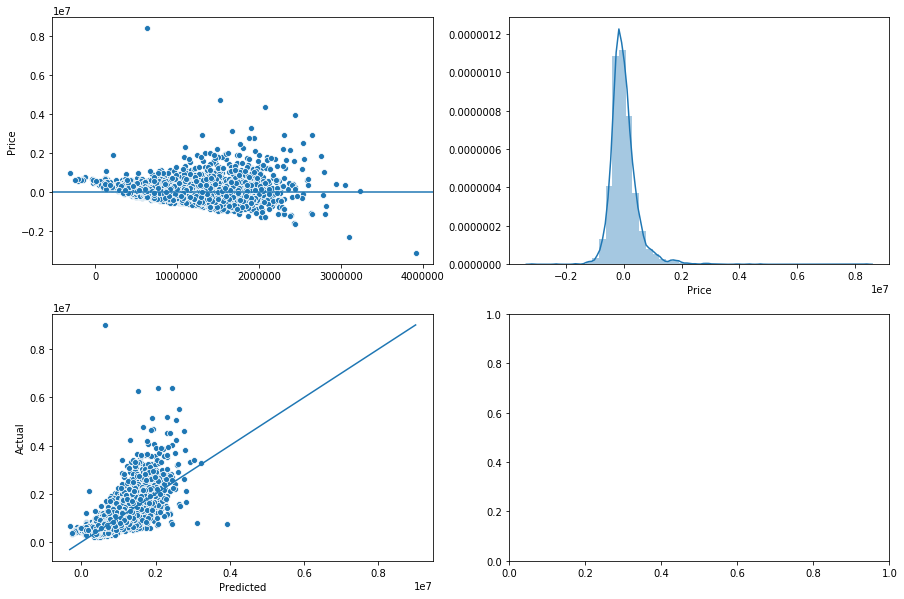

In [26]:
cols =['Rooms','Distance','Bathroom','Car','Landsize','BuildingArea','YearBuilt']

X = features.df[cols]
y = features.df['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=3)

lr = LinearRegression()
lr.fit(X_train,y_train)
print('training score: ',lr.score(X_train, y_train))
print('testing score: ', lr.score(X_test, y_test))
print('cross val score: ', cross_val_score(lr,X,y, cv=6))

mdst.diagnostic_graphs_LR(y_test, lr.predict(X_test))

### K best - f_regression

In [27]:
cols = [col for col in list(set(features.df.columns)) if 'Price' not in col and col not in features.categorical_col_names]

X = features.df[cols]
y = features.df['Price']

In [28]:
skb = SelectKBest(score_func=f_regression, k=30)
skb.fit(X, y)

c:\python36-32\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
c:\python36-32\lib\site-packages\sklearn\feature_selection\univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
c:\python36-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\python36-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\python36-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SelectKBest(k=30, score_func=<function f_regression at 0x114F6B28>)

In [29]:
result = pd.DataFrame(skb.scores_, index=cols).sort_values(by=0, ascending=False).head(50)
kbest50_f_reg = list(result.index)
result


,0
BuildingArea capped_outliers/Distance bin,7022.958322
Rooms capped_outliers/Distance bin,4984.596727
BuildingArea capped_outliers,4495.396110
Bathroom capped_outliers/Distance bin,4236.987156
Rooms Bathroom,3526.253749
Rooms/Distance,3130.520136
Rooms capped_outliers,2983.258802
Rooms,2929.930077
Bathroom,2795.753661
Rooms^2,2671.907835


### Recursive Feature Elimination

#### RFECV

In [30]:
cols = [col for col in list(set(features.df.columns)) if 'Price' not in col and col not in features.categorical_col_names]

X = features.df[cols]
y = features.df['Price']

#split test and train both for faster performance and less bias
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=3)

# crossvalidated recursive feature elimination with random forest regressor
rfe = RFECV(LinearRegression(), step=1)
rfe.fit(X_train, y_train)

rfe.score(X_test, y_test)

0.6702044827317856

In [31]:
rfecv_rankings = pd.Series(rfe.ranking_, index=cols)
rfecv_rankings.value_counts()
#RFECV kept 38 of the features

1     38
29     1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
30     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
15     1
dtype: int64

In [32]:
# these are the features that were thrown out
rfecv_rankings.sort_values()[38:]

Bathroom^2                                2
Distance Car                              3
Distance^2                                4
Distance                                  5
Car YearBuilt                             6
BuildingArea/Distance                     7
BuildingArea capped_outliers              8
BuildingArea                              9
Rooms BuildingArea                       10
Bathroom YearBuilt                       11
Landsize capped_outliers                 12
Bathroom BuildingArea                    13
Car BuildingArea                         14
Distance YearBuilt                       15
Landsize/Distance                        16
Landsize capped_outliers/Distance bin    17
Landsize                                 18
Rooms Landsize                           19
YearBuilt^2                              20
Distance BuildingArea                    21
Bathroom Landsize                        22
Car Landsize                             23
Distance Landsize               

In [33]:
# save feature set
rfecv_features = list(rfecv_rankings[rfecv_rankings == 1].index)

#### RFE  5 features

In [34]:
cols = [col for col in list(set(features.df.columns)) if 'Price' not in col and col not in features.categorical_col_names]

X = features.df[cols]
y = features.df['Price']

#split test and train both for faster performance and less bias
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=3)

# crossvalidated recursive feature elimination with random forest regressor
rfe = RFE(Ridge(alpha=75), step=1, n_features_to_select=20)
rfe.fit(X_train, y_train)

c:\python36-32\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.038184e-18
  overwrite_a=True).T
c:\python36-32\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.893729e-18
  overwrite_a=True).T
c:\python36-32\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.810184e-18
  overwrite_a=True).T
c:\python36-32\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.688073e-17
  overwrite_a=True).T
c:\python36-32\lib\site-packages\sklearn\linear_

RFE(estimator=Ridge(alpha=75, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
  n_features_to_select=20, step=1, verbose=0)

In [35]:
rfe.score(X_test, y_test)

0.6064813993404667

In [36]:
rfe_rankings = pd.Series(rfe.ranking_, index=cols)

#RFECV kept 38 of the features
rfe_rankings.sort_values()

PI                                        1
Bathroom/Distance                         1
Bathroom Car                              1
u                                         1
Car                                       1
Distance bin                              1
South-Eastern Metropolitan                1
Rooms capped_outliers                     1
Distance capped_outliers                  1
t                                         1
VB                                        1
Eastern Victoria                          1
Western Metropolitan                      1
Rooms/Distance                            1
Northern Victoria                         1
Southern Metropolitan                     1
Bathroom capped_outliers/Distance bin     1
Rooms                                     1
Eastern Metropolitan                      1
Car capped_outliers                       1
SA                                        2
Bathroom                                  3
Rooms Bathroom                  

### Performance and feature importance

#### Priority: prediction

training score:  0.7013911789873193
testing score:  0.6676735308143169
cross val score:  [0.71568274 0.65719449 0.65933504 0.6295841  0.67219672 0.70379745]


c:\python36-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


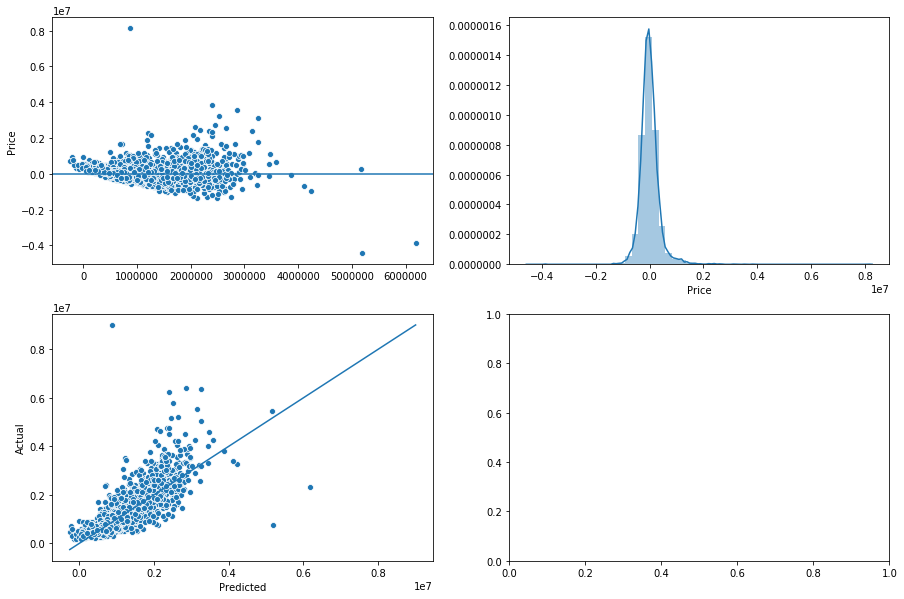

In [38]:

X = features.df[rfecv_features]
y = features.df['Price']

#split test and train both for faster performance and less bias
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=3)

# crossvalidated recursive feature elimination with random forest regressor
lr = Ridge(alpha=35)
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

print('training score: ',lr.score(X_train, y_train))
print('testing score: ', lr.score(X_test, y_test))
print('cross val score: ', cross_val_score(lr,X,y, cv=6))

mdst.diagnostic_graphs_LR(y_test, lr.predict(X_test))

In [39]:
def display_coef(linear_model, X):
    coeffs = pd.DataFrame()
    coeffs['coeff'] = linear_model.coef_.reshape(-1)
    
    coeffs['feature'] = X.columns
    coeffs['abs_coeff'] = abs(coeffs['coeff'])
    
    return coeffs.sort_values(by='abs_coeff', ascending=False)

In [40]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [41]:
display_coef(lr, X)

,coeff,feature,abs_coeff
32,443405.454,Southern Metropolitan,443405.454
9,333711.664,Distance bin,333711.664
18,-264223.689,u,264223.689
36,220135.486,South-Eastern Metropolitan,220135.486
3,202490.766,Rooms/Distance,202490.766
6,184795.401,Eastern Metropolitan,184795.401
11,163381.358,Car/Distance,163381.358
1,-146122.355,Bathroom capped_outliers/Distance bin,146122.355
26,144273.740,Eastern Victoria,144273.740
34,138964.451,Rooms,138964.451


#### Priority: interpretation

training score:  0.6035637876092688
testing score:  0.5810019486437057
cross val score:  [0.61677339 0.60368517 0.54340617 0.5561121  0.57288467 0.60082853]


c:\python36-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


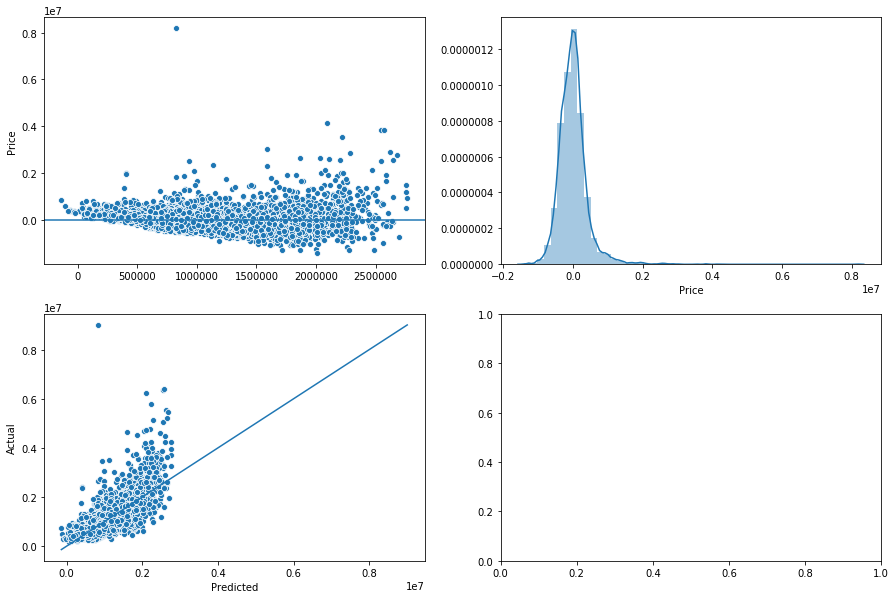

In [42]:
cols = []
cols += features.dummy_dct['Regionname']
cols += features.dummy_dct['Type']
cols += ['YearBuilt capped_outliers', 'Rooms capped_outliers/Distance bin', 'BuildingArea capped_outliers/Distance bin', 'Car capped_outliers/Distance bin']

X = features.df[cols]
y = features.df['Price']

#split test and train both for faster performance and less bias
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.5, random_state=3)

# crossvalidated recursive feature elimination with random forest regressor
lr = Ridge(alpha=35)
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

print('training score: ',lr.score(X_train, y_train))
print('testing score: ', lr.score(X_test, y_test))
print('cross val score: ', cross_val_score(lr,X,y, cv=6))

mdst.diagnostic_graphs_LR(y_test, lr.predict(X_test))

In [43]:
display_coef(lr, X)

,coeff,feature,abs_coeff
4,413892.729,Southern Metropolitan,413892.729
8,-264499.676,u,264499.676
3,202152.672,South-Eastern Metropolitan,202152.672
5,-175282.721,Western Metropolitan,175282.721
0,100585.589,Eastern Metropolitan,100585.589
7,-100542.202,t,100542.202
10,85814.676,Rooms capped_outliers/Distance bin,85814.676
6,-76859.420,Western Victoria,76859.420
1,73989.937,Eastern Victoria,73989.937
12,26479.272,Car capped_outliers/Distance bin,26479.272


# Conlusions

- Best predictive power came from Random Forest (r^2 of .77)

- Most important singular feature: building area capped_outlier/Distance bin

- Region effect on price from best to worst:
    1. Southern Metropolitan
    2. South-Eastern Metropolitan
    3. Eastern Metropolitan
    4. Eastern Victoria
    5. Northern Victoria
    6. Northern Metropolitan
    7. Western Victoria
    8. Western Metropolitan
    
- Housing type effect on price from best to worst:
    1. h
    2. u
    3. t
    
- Rooms, Bathrooms, Building Area, Landsize, Car spots... effect on price is best understood in relation to distance from the city center. All of these become much more expensive closer to the city center, but not in a linear fashion. Changes in distance from the city center tend to affect price more when you are closer to the city center.

- Predictive power was often improved when capping outliers (mostly upper outliers), suggesting that the features traditional effect on price diminishes at extreme values. 